In [1]:
from pathlib import Path
from nifreeze.data import pet
from nifreeze.model import PETModel
from nifreeze.estimator import PETMotionEstimator
from nifreeze import __file__ as package_path

# Get the installed package directory
package_dir = Path('/Users/martinnorgaard/Documents/GitHub/nifreeze_dev')

# set debug_dir
debug_output_path =  package_dir / 'docs/notebooks/debug_run'

# Dynamically construct paths to the PET data within the installed package
pet_image_path = package_dir / "data/pet/sub-01/ses-baseline/pet/sub-01_ses-baseline_pet.nii.gz"
pet_json_path = package_dir / "data/pet/sub-01/ses-baseline/pet/sub-01_ses-baseline_pet.json"

# Load PET dataset
pet_dataset = pet.PET.load(str(pet_image_path), str(pet_json_path))


In [3]:
# setup PET model
model = PETModel(
    dataset=pet_dataset,
    timepoints=pet_dataset.midframe_time,
    xlim=pet_dataset.total_duration,
    n_ctrl=7,
    pad_mode='edge',
    pad_strategy='midframe',
)

# instantiate estimator
estimator = PETMotionEstimator(model=model)

# estimate affines
affines = estimator.run(pet_dataset, omp_nthreads=4, n_jobs=4, debug_dir=debug_output_path)

/Users/martinnorgaard/Dropbox/Mac/Documents/GitHub/nifreeze_dev/src/nifreeze/model/pet.py:78: UserWarning: No mask provided; consider using a mask to avoid issues in model optimization.
  super().__init__(dataset, **kwargs)
Estimating PET motion: 21it [24:11, 69.10s/it]


In [4]:
import numpy as np
import pandas as pd

def extract_motion_parameters(affine):
    """Extract translation (mm) and rotation (degrees) parameters from an affine matrix."""
    translation = affine[:3, 3]
    rotation_rad = np.arctan2(
        [affine[2, 1], affine[0, 2], affine[1, 0]],
        [affine[2, 2], affine[0, 0], affine[1, 1]]
    )
    rotation_deg = np.rad2deg(rotation_rad)
    return (*translation, *rotation_deg)

def compute_fd(motion_parameters):
    """Compute Framewise Displacement from motion parameters."""
    translations = motion_parameters[:, :3]
    rotations_deg = motion_parameters[:, 3:]
    rotations_rad = np.deg2rad(rotations_deg)
    
    # Compute differences between consecutive frames
    d_translations = np.vstack([np.zeros((1, 3)), np.diff(translations, axis=0)])
    d_rotations = np.vstack([np.zeros((1, 3)), np.diff(rotations_rad, axis=0)])
    
    # Convert rotations from radians to displacement on a sphere (radius 50 mm)
    radius = 50  # typical head radius in mm
    rotation_displacement = d_rotations * radius
    
    # Compute FD as sum of absolute differences
    fd = np.sum(np.abs(d_translations) + np.abs(rotation_displacement), axis=1)
    return fd

# Assume 'affines' is the list of affine matrices you computed earlier
motion_parameters = []

for idx, affine in enumerate(affines):
    tx, ty, tz, rx, ry, rz = extract_motion_parameters(affine)
    motion_parameters.append([tx, ty, tz, rx, ry, rz])

motion_parameters = np.array(motion_parameters)
fd = compute_fd(motion_parameters)

# Creating a DataFrame for better visualization
df_motion = pd.DataFrame({
    "Frame": np.arange(len(fd)),
    "Translation X": motion_parameters[:, 0],
    "Translation Y": motion_parameters[:, 1],
    "Translation Z": motion_parameters[:, 2],
    "Rotation X": motion_parameters[:, 3],
    "Rotation Y": motion_parameters[:, 4],
    "Rotation Z": motion_parameters[:, 5],
    "Framewise Displacement (mm)": fd
})

# Save to TSV file
df_motion.to_csv(debug_output_path / 'motion_parameters.tsv', sep='\t', index=False)

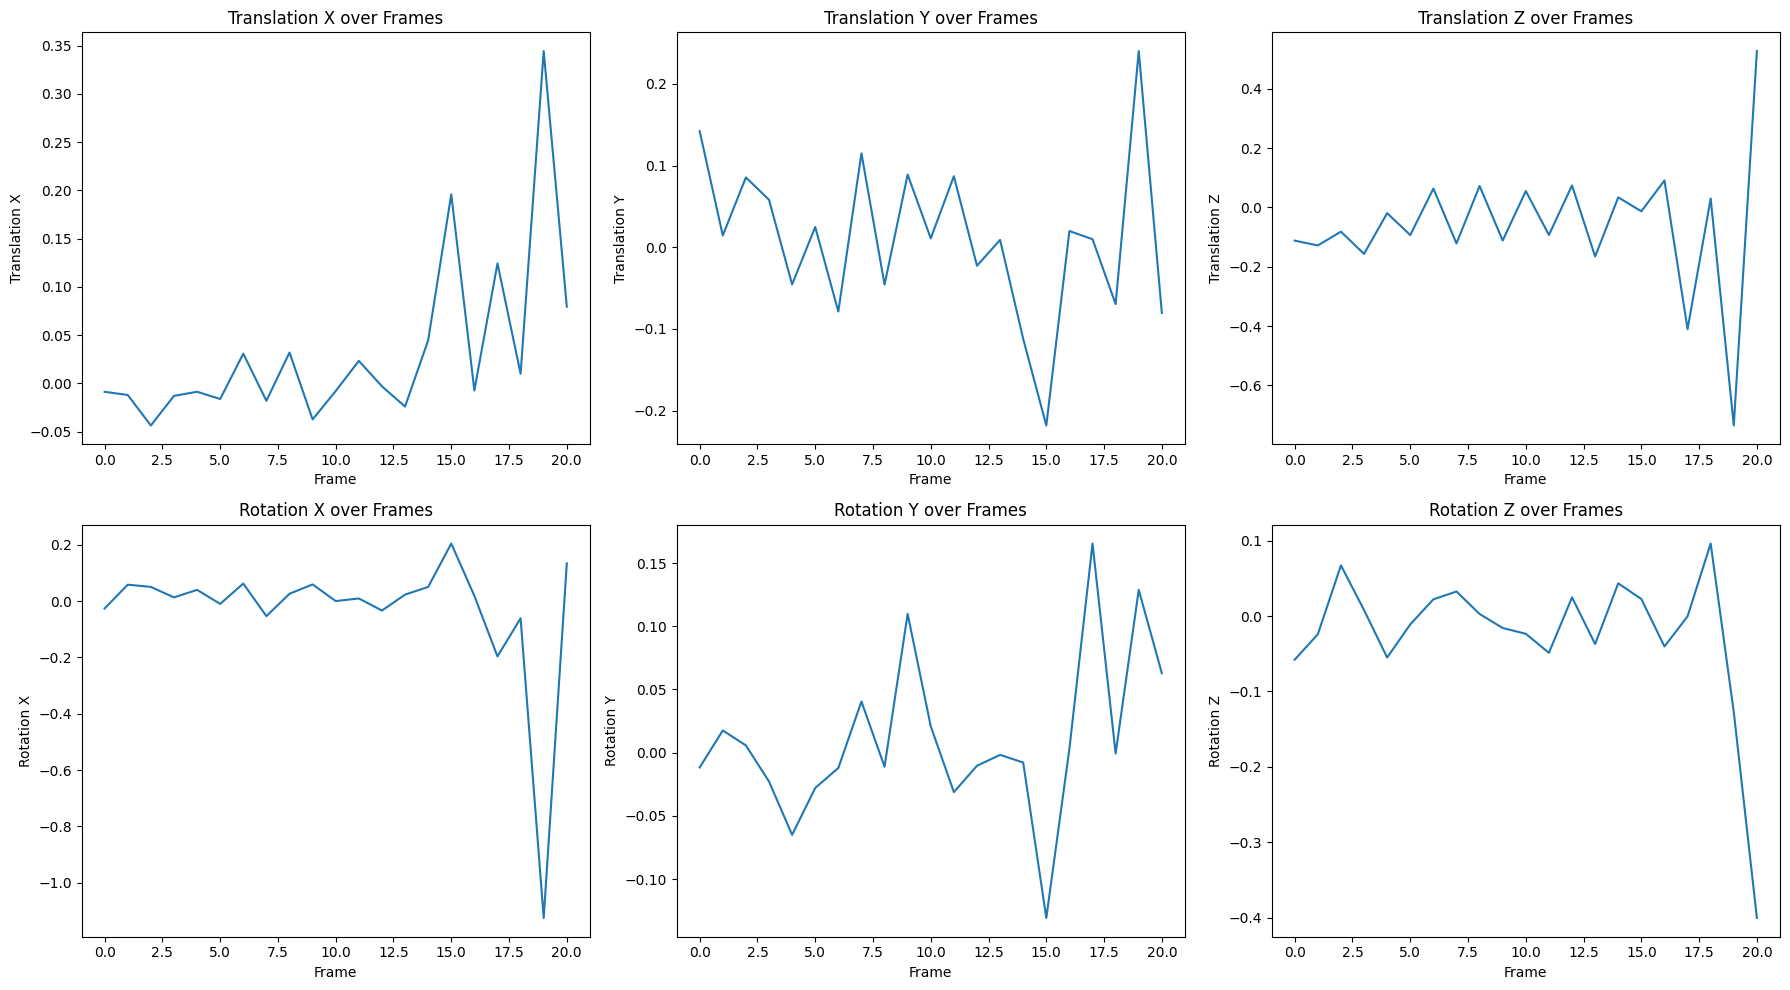

In [5]:
# Set up the matplotlib figure
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18, 10))

# Translation plots
plt.subplot(2, 3, 1)
sns.lineplot(x='Frame', y='Translation X', data=df_motion)
plt.title('Translation X over Frames')

plt.subplot(2, 3, 2)
sns.lineplot(x='Frame', y='Translation Y', data=df_motion)
plt.title('Translation Y over Frames')

plt.subplot(2, 3, 3)
sns.lineplot(x='Frame', y='Translation Z', data=df_motion)
plt.title('Translation Z over Frames')

# Rotation plots
plt.subplot(2, 3, 4)
sns.lineplot(x='Frame', y='Rotation X', data=df_motion)
plt.title('Rotation X over Frames')

plt.subplot(2, 3, 5)
sns.lineplot(x='Frame', y='Rotation Y', data=df_motion)
plt.title('Rotation Y over Frames')

plt.subplot(2, 3, 6)
sns.lineplot(x='Frame', y='Rotation Z', data=df_motion)
plt.title('Rotation Z over Frames')

plt.tight_layout()
plt.show()

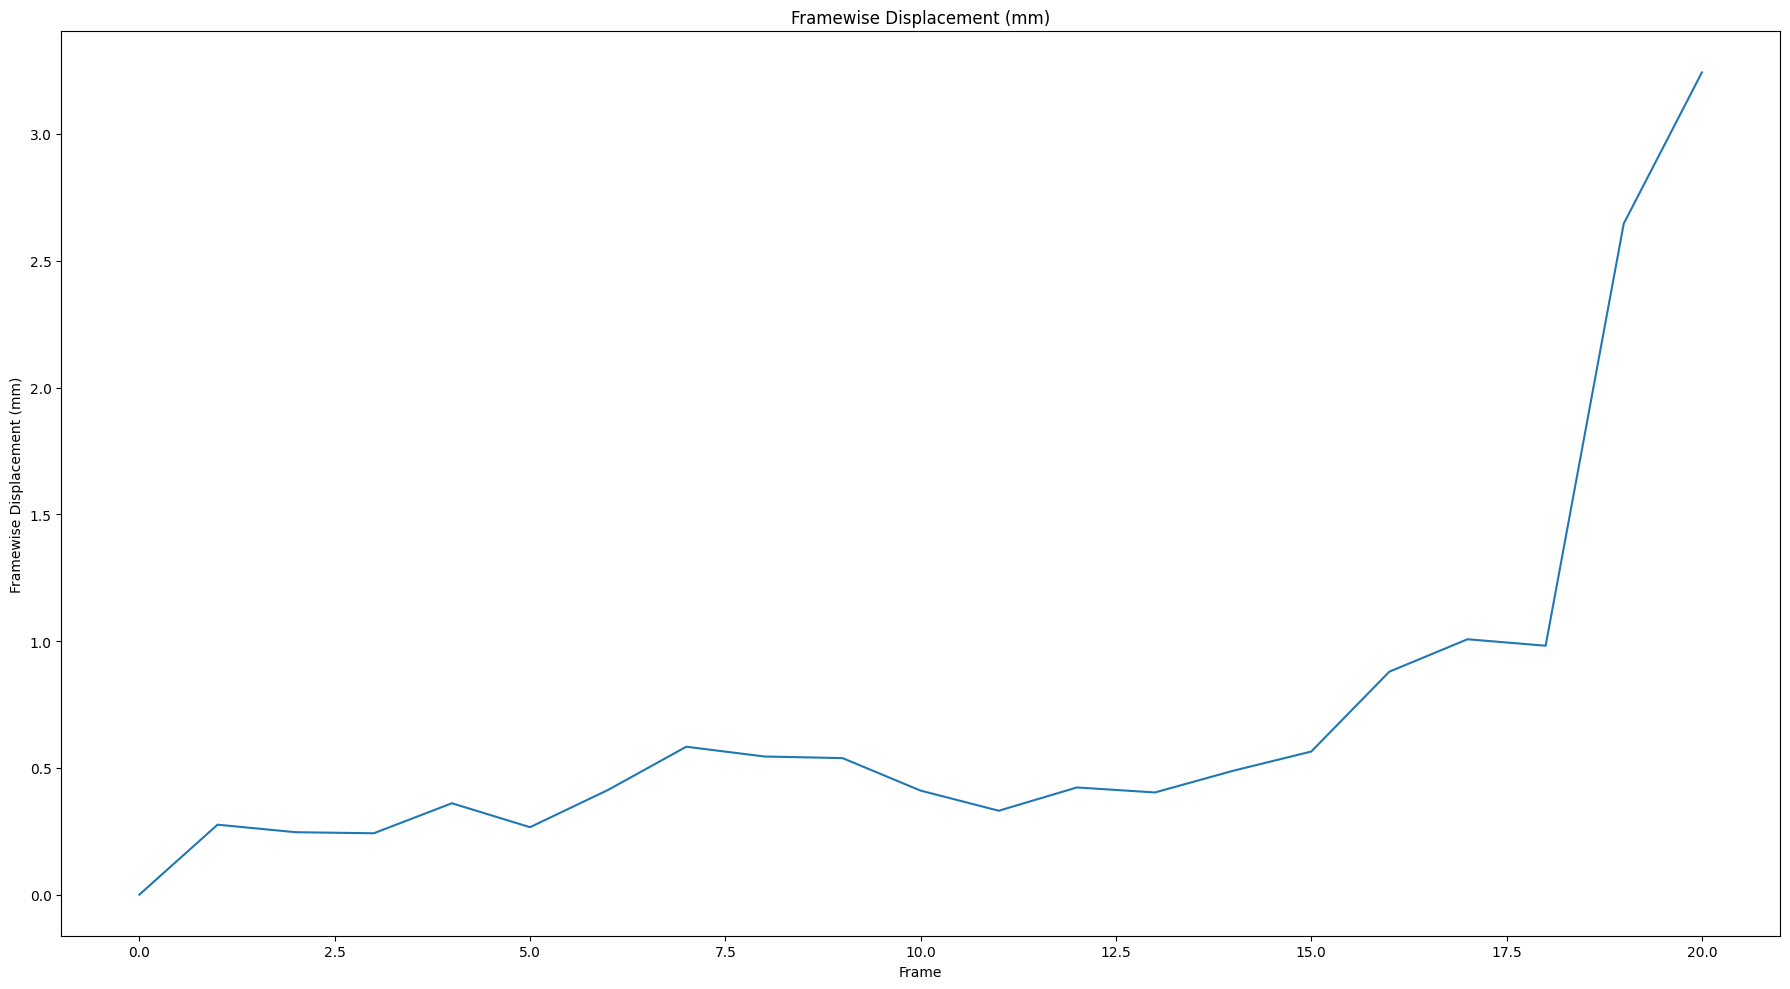

In [6]:
plt.figure(figsize=(18, 10))
sns.lineplot(x='Frame', y='Framewise Displacement (mm)', data=df_motion)
plt.title('Framewise Displacement (mm)')

plt.tight_layout()
plt.show()